# Aging aware training

$$ \min_\theta \,\int_{t=0}^{1} \; L(\theta(t)) \, dt $$
where  $\theta(t)$ is a fitted model of the conductance over time

## Monte Carlo approximation:

### Introduction

The goal is to integrate the following formular
$$
\int_t f(t){\rm d}t
$$
Rectangular approximation is 
$$
\sum_n f[n\Delta k]\Delta k
$$
The problem is that, if the sampling rate is lower than twice the frequencce of the function, the error would be large, e.g., integrating a $f(t)=\sin(2\pi (t+\frac{1}{4}))$ with sampling rate $\Delta k=1$, i.e.,
$$
\int_tf(t){\rm d}t\approx\sum_n \sin \left(2\pi (n+\frac{1}{4})\right)=n,
$$
which is obviously wrong.

### Monte Carlo Approximation

Recall the definition of **Expectation** of a distribution
$$
\begin{align}
\mathbb{E}\{x\}&=\int_x x\cdot p(x) {\rm d}x\\&\approx \frac{1}{N}\sum_{n=1}^N x_n,\ x_n\sim p(x)
\end{align}
$$
Further, 
$$
\begin{align}
\mathbb{E}\{f(x)\}&=\int_x f(x)\cdot p(x) {\rm d}x\\&\approx \frac{1}{N}\sum_{n=1}^N f(x_n),\ x_n\sim p(x)
\end{align}
$$
For a given integration task $\int_x f(x) {\rm d}x$, we can approximate this by
$$
\int_x f(x) {\rm d}x=\int_x f(x)\cdot 1 {\rm d}x=\int_x f(x)\cdot \frac{p(x)}{p(x)} {\rm d}x=\int_x\frac{f(x)}{p(x)}\cdot p(x) {\rm d}x=\mathbb{E}\left\{\frac{f(x)}{p(x)}\right\}\approx\frac{1}{N}\sum_{n=1}^N \frac{f(x_n)}{p(x_n)},\ x_n\sim p(x)
$$
Let $p(x)$ is a uniform distribution, e.g., $p(x)=\frac{1}{b-a},\ x\in[a,b]$, we have
$$
\int_x f(x) {\rm d}x\approx\frac{1}{N}\sum_{n=1}^N \frac{f(x_n)}{p(x_n)}=\frac{b-a}{N}\sum_{n=1}^N f(x_n),\ x\sim p(x).
$$
Let $b=1$ and $a=0$, 
$$
\int_x f(x) {\rm d}x\approx\frac{1}{N}\sum_{n=1}^N f(x_n),\ x\sim p(x),
$$
i.e., we can approximate the integration by averaging the randomly sampled value $f(x)$, with $x$ following uniform distribution.

Moreover, the method in the introduction is a special case of Monte Carlo method.
## Aging Aware Training

The goal of aging aware training is
$$
\min_{\theta_{\rm init}} \int_{t=0}^1 L(\theta(t)){\rm d}t,
$$
where $\theta(t)=\theta_{\rm init}\cdot\mathop{A}(t)$ denotes the aging of the resistors. Using Monto Carlo method, it is converted to
$$
\min_{\theta_{\rm init}} \frac{1}{K}\sum_{k\in \mathfrak{K} } L \left(\theta[k]\right),
$$
where $\mathfrak{K}$ is a set of $K$ uniform randomly sampled timestamps $k\in[0,1]$.

To minimize this function, i.e., $\frac{1}{N}\sum_{k\in \mathfrak{K} } L \left(\theta[k]\right)$, we apply intuitively the gradient descent:
$$
\begin{align}
\theta_{\rm init}&:=\theta_{\rm init} - \alpha\cdot\nabla_{\theta_{\rm init}}\left(\frac{1}{K}\sum_{k\in \mathfrak{K} } L \left(\theta[k]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{K}\cdot\nabla_{\theta_{\rm init}}\left(\sum_{k\in \mathfrak{K} } L \left(\theta[k]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{K}\cdot \sum_{k\in \mathfrak{K} } \nabla_{\theta_{\rm init}}\left(L \left(\theta[k]\right)\right)\\
\end{align}
$$

# Get aging model

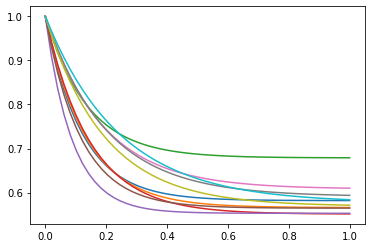

In [1]:
import pickle
import pNN_aging_aware as pnn
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import data
sys.path.append(os.path.join(os.getcwd(), 'Aging_Model'))
import torch
from torch.autograd import Variable
import torch.nn.functional as F

with open(os.path.join(os.getcwd(), 'Aging_Model', 'exp_aging_model.p'), 'rb') as f:
    age_generator = pickle.load(f)
vals = np.linspace(0,1)
age_models = age_generator.get_models(10)
for k in age_models:
    plt.plot(vals, k(vals));

## Prepare data

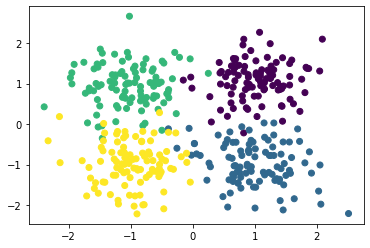

(torch.Size([280, 2]), torch.Size([280]))

In [2]:
np.random.seed(1)
X, Y = data.GenerateData(N=400, var=0.5, plot=True)
X_train, Y_train, X_valid, Y_valid = data.SplitData(X, Y, 0.7)
X_train, Y_train, X_valid, Y_valid = X_train.T, Y_train.T.flatten(), X_valid.T, Y_valid.T.flatten()

x_train, y_train = torch.from_numpy(X_train).type(torch.FloatTensor), torch.from_numpy(Y_train).type(torch.LongTensor)
x_valid, y_valid = torch.from_numpy(X_valid).type(torch.FloatTensor), torch.from_numpy(Y_valid).type(torch.LongTensor)
x_train, y_train = Variable(x_train), Variable(y_train)
x_valid, y_valid = Variable(x_valid), Variable(y_valid)
x_train.shape, y_train.shape

## Try to get aged theta

In [3]:
import importlib
importlib.reload(pnn)

# generate NN, the initial time, i.e., pnn.PNNLayer.t = 0.
mypnn = torch.nn.Sequential(pnn.PNNLayer(2,5, age_generator),
                            pnn.PNNLayer(5,5, age_generator),
                            pnn.PNNLayer(5,4, age_generator))
counter = 1
for i in mypnn:
    print(f"The {counter}-th layer:")
    counter += 1
    
    print(f"theta at t={i.t}\n", i.theta_aged)    # print theta
    i.t = 0.1         # change time
    print(f"theta at t={i.t}\n", i.theta_aged)    # print aged theta
    
    print("\n")

The 1-th layer:
theta at t=0
 tensor([[ 0.9041,  0.1277, 10.3696, 46.7219],
        [ 0.9285,  0.5969, 18.9543, 86.1254],
        [ 0.2266,  0.6893, 10.3236, 47.1881],
        [ 0.5579,  0.8067, 21.1571, 96.6131],
        [ 0.6020,  0.6120, 17.0130, 77.5360]], grad_fn=<ViewBackward>)
theta at t=0.1
 tensor([[ 0.7646,  0.1064,  8.3939, 32.4763],
        [ 0.7247,  0.5006, 15.5114, 67.6968],
        [ 0.1965,  0.5267,  8.1992, 37.7068],
        [ 0.4358,  0.6681, 16.9669, 70.6663],
        [ 0.5025,  0.4764, 13.2960, 61.5052]], grad_fn=<ViewBackward>)


The 2-th layer:
theta at t=0
 tensor([[7.4796e-02, 8.7581e-01, 4.0739e-01, 4.3573e-01, 4.2921e-01, 1.1497e+01,
         5.1009e+01],
        [9.7070e-01, 7.8525e-01, 9.4625e-01, 9.3372e-01, 7.9080e-01, 2.6666e+00,
         8.6114e+00],
        [6.9238e-01, 8.3669e-01, 4.1162e-01, 4.1830e-01, 6.1488e-01, 7.0049e+00,
         2.9813e+01],
        [9.1889e-01, 1.8035e-01, 8.4424e-01, 8.5104e-01, 5.4735e-01, 2.0090e+01,
         8.9473e+01],


# Definations

In [4]:
MyAgedPNN = torch.nn.Sequential(pnn.PNNLayer(2,3, age_generator),
                                pnn.PNNLayer(3,3, age_generator),
                                pnn.PNNLayer(3,4, age_generator))
alpha = 0.005
m = 0.3
T = 0.1
K = 35
optimizer_aged = torch.optim.Adam(MyAgedPNN.parameters(), lr=0.1/K)
MyAgedPNN

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
  (2): PNNLayer()
)

In [5]:
MyPNN = torch.nn.Sequential(pnn.PNNLayer(2,3, age_generator),
                            pnn.PNNLayer(3,3, age_generator),
                            pnn.PNNLayer(3,4, age_generator))
optimizer = torch.optim.Adam(MyPNN.parameters(), lr=alpha)
MyPNN

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
  (2): PNNLayer()
)

In [6]:
myparameter = []
myloss = []
for s in range(2000):
    optimizer.zero_grad()
    
    prediction = MyPNN(x_train)
    loss = pnn.LossFunction(prediction, y_train, m, T)
    loss.backward()
    
    optimizer.step()

    if s % 10 == 0:
        temp = []
        prediction_valid = MyPNN(x_valid)
        p = torch.max(F.softmax(prediction_valid, dim=0), 1)[1]
        pred_y = p.data.numpy().squeeze()
        acc_valid = sum(pred_y == Y_valid) / Y_valid.shape[0]
        loss_valid = pnn.LossFunction(prediction_valid, y_valid, m, T)

        temp = [l.theta_.data.clone() for l in MyPNN]
        myparameter.append(temp)
        myloss.append(loss_valid.data)
        print(f'| Epoch: {s:-6d} | Accuracy: {acc_valid:.5f} | Loss: {loss_valid.data:.5f} |')
print('Finished.')

| Epoch:      0 | Accuracy: 0.10000 | Loss: 0.87985 |
| Epoch:     10 | Accuracy: 0.10833 | Loss: 0.82727 |
| Epoch:     20 | Accuracy: 0.18333 | Loss: 0.78965 |
| Epoch:     30 | Accuracy: 0.21667 | Loss: 0.75853 |
| Epoch:     40 | Accuracy: 0.23333 | Loss: 0.73860 |
| Epoch:     50 | Accuracy: 0.24167 | Loss: 0.72527 |
| Epoch:     60 | Accuracy: 0.25000 | Loss: 0.71345 |
| Epoch:     70 | Accuracy: 0.30833 | Loss: 0.70042 |
| Epoch:     80 | Accuracy: 0.35833 | Loss: 0.68208 |
| Epoch:     90 | Accuracy: 0.45833 | Loss: 0.65937 |
| Epoch:    100 | Accuracy: 0.47500 | Loss: 0.63877 |
| Epoch:    110 | Accuracy: 0.52500 | Loss: 0.62122 |
| Epoch:    120 | Accuracy: 0.63333 | Loss: 0.60463 |
| Epoch:    130 | Accuracy: 0.76667 | Loss: 0.58552 |
| Epoch:    140 | Accuracy: 0.86667 | Loss: 0.56347 |
| Epoch:    150 | Accuracy: 0.88333 | Loss: 0.53860 |
| Epoch:    160 | Accuracy: 0.88333 | Loss: 0.50829 |
| Epoch:    170 | Accuracy: 0.88333 | Loss: 0.47038 |
| Epoch:    180 | Accuracy: 

| Epoch:   1530 | Accuracy: 0.92500 | Loss: 0.12892 |
| Epoch:   1540 | Accuracy: 0.92500 | Loss: 0.12891 |
| Epoch:   1550 | Accuracy: 0.92500 | Loss: 0.12885 |
| Epoch:   1560 | Accuracy: 0.92500 | Loss: 0.12874 |
| Epoch:   1570 | Accuracy: 0.92500 | Loss: 0.12875 |
| Epoch:   1580 | Accuracy: 0.92500 | Loss: 0.12862 |
| Epoch:   1590 | Accuracy: 0.92500 | Loss: 0.12864 |
| Epoch:   1600 | Accuracy: 0.92500 | Loss: 0.12852 |
| Epoch:   1610 | Accuracy: 0.92500 | Loss: 0.12842 |
| Epoch:   1620 | Accuracy: 0.92500 | Loss: 0.12827 |
| Epoch:   1630 | Accuracy: 0.92500 | Loss: 0.12822 |
| Epoch:   1640 | Accuracy: 0.92500 | Loss: 0.12813 |
| Epoch:   1650 | Accuracy: 0.92500 | Loss: 0.12794 |
| Epoch:   1660 | Accuracy: 0.92500 | Loss: 0.12773 |
| Epoch:   1670 | Accuracy: 0.92500 | Loss: 0.12769 |
| Epoch:   1680 | Accuracy: 0.92500 | Loss: 0.12764 |
| Epoch:   1690 | Accuracy: 0.92500 | Loss: 0.12756 |
| Epoch:   1700 | Accuracy: 0.92500 | Loss: 0.12749 |
| Epoch:   1710 | Accuracy: 

tensor(0.1040)

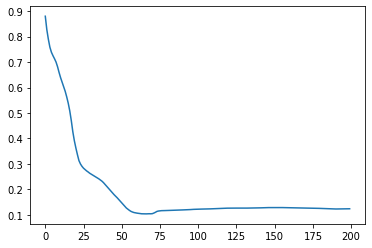

In [7]:
plt.plot(myloss);
best = np.argmin(myloss)
bestparameter = myparameter[best]
for l in range(len(bestparameter)):
    MyPNN[l].theta_.data = bestparameter[l]
prediction_valid = MyPNN(x_valid)
loss_valid = pnn.LossFunction(prediction_valid, y_valid, m, T)
loss_valid.data

In [8]:
myparameter = []
myloss = []
for s in range(2000):
    optimizer_aged.zero_grad()
    
    TimeSet = np.random.rand(K)
    for k in TimeSet:
        for i in MyAgedPNN:
            i.t = k
        prediction = MyAgedPNN(x_train)
        loss = pnn.LossFunction(prediction, y_train, m, T)
        loss.backward()
    
    optimizer_aged.step()

    if s % 10 == 0:
        temp = []
        avg_loss = 0
        avg_acc = 0
        
        test_time = np.linspace(0,1,100)
        for test_t in test_time:
            for i in MyAgedPNN:
                i.t = test_t    
            prediction = MyAgedPNN(x_valid)
            loss = pnn.LossFunction(prediction, y_valid, m, T)
            p = torch.max(F.softmax(prediction, dim=0), 1)[1]
            pred_y = p.data.numpy().squeeze()
            acc = sum(pred_y == Y_valid) / Y_valid.shape[0]
            
            avg_loss += loss.data
            avg_acc += acc
        
        avg_loss /= 100
        avg_acc /= 100
        
        myloss.append(avg_loss)
        temp = [l.theta_.data.clone() for l in MyAgedPNN]
        myparameter.append(temp)
        
        print(f'| Epoch: {s:-6d} | Accuracy: {avg_acc:.5f} | Loss: {avg_loss:.5f} |')

print('Finished.')

| Epoch:      0 | Accuracy: 0.05825 | Loss: 1.00992 |
| Epoch:     10 | Accuracy: 0.06500 | Loss: 0.99146 |
| Epoch:     20 | Accuracy: 0.08000 | Loss: 0.97606 |
| Epoch:     30 | Accuracy: 0.09650 | Loss: 0.96224 |
| Epoch:     40 | Accuracy: 0.11967 | Loss: 0.94979 |
| Epoch:     50 | Accuracy: 0.15642 | Loss: 0.93798 |
| Epoch:     60 | Accuracy: 0.21083 | Loss: 0.92653 |
| Epoch:     70 | Accuracy: 0.27742 | Loss: 0.91534 |
| Epoch:     80 | Accuracy: 0.33800 | Loss: 0.90429 |
| Epoch:     90 | Accuracy: 0.40517 | Loss: 0.89374 |
| Epoch:    100 | Accuracy: 0.42817 | Loss: 0.88296 |
| Epoch:    110 | Accuracy: 0.44617 | Loss: 0.87243 |
| Epoch:    120 | Accuracy: 0.47775 | Loss: 0.86301 |
| Epoch:    130 | Accuracy: 0.49300 | Loss: 0.85389 |
| Epoch:    140 | Accuracy: 0.49783 | Loss: 0.84600 |
| Epoch:    150 | Accuracy: 0.49942 | Loss: 0.83968 |
| Epoch:    160 | Accuracy: 0.49717 | Loss: 0.83341 |
| Epoch:    170 | Accuracy: 0.48517 | Loss: 0.82719 |
| Epoch:    180 | Accuracy: 

| Epoch:   1520 | Accuracy: 0.94942 | Loss: 0.09106 |
| Epoch:   1530 | Accuracy: 0.94950 | Loss: 0.09108 |
| Epoch:   1540 | Accuracy: 0.94942 | Loss: 0.09122 |
| Epoch:   1550 | Accuracy: 0.94933 | Loss: 0.09124 |
| Epoch:   1560 | Accuracy: 0.94925 | Loss: 0.09122 |
| Epoch:   1570 | Accuracy: 0.94933 | Loss: 0.09113 |
| Epoch:   1580 | Accuracy: 0.94933 | Loss: 0.09102 |
| Epoch:   1590 | Accuracy: 0.94950 | Loss: 0.09093 |
| Epoch:   1600 | Accuracy: 0.94942 | Loss: 0.09083 |
| Epoch:   1610 | Accuracy: 0.94867 | Loss: 0.09068 |
| Epoch:   1620 | Accuracy: 0.94833 | Loss: 0.09065 |
| Epoch:   1630 | Accuracy: 0.94775 | Loss: 0.09066 |
| Epoch:   1640 | Accuracy: 0.94842 | Loss: 0.09049 |
| Epoch:   1650 | Accuracy: 0.94792 | Loss: 0.09042 |
| Epoch:   1660 | Accuracy: 0.94800 | Loss: 0.09035 |
| Epoch:   1670 | Accuracy: 0.94833 | Loss: 0.09031 |
| Epoch:   1680 | Accuracy: 0.94833 | Loss: 0.09036 |
| Epoch:   1690 | Accuracy: 0.94750 | Loss: 0.09037 |
| Epoch:   1700 | Accuracy: 

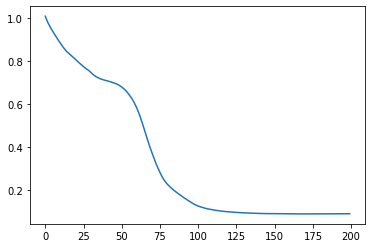

In [9]:
plt.plot(myloss);
best = np.argmin(myloss)
bestparameter = myparameter[best]
for l in range(len(bestparameter)):
    MyAgedPNN[l].theta_.data = bestparameter[l]

In [10]:
import evaluation
import importlib
importlib.reload(evaluation)

test_time = np.linspace(0,1,100)
my_aged_acc = []
my_acc = []
my_aged_maa = []
my_maa = []

for test_t in test_time:
    for i in MyAgedPNN:
        i.t = test_t
    for i in MyPNN:
        i.t = test_t
    
    my_aged_acc.append(evaluation.basic(MyAgedPNN, x_valid, y_valid))
    my_acc.append(evaluation.basic(MyPNN, x_valid, y_valid))
    
    my_aged_maa.append(evaluation.maa(MyAgedPNN, x_valid, y_valid))
    my_maa.append(evaluation.maa(MyPNN, x_valid, y_valid))

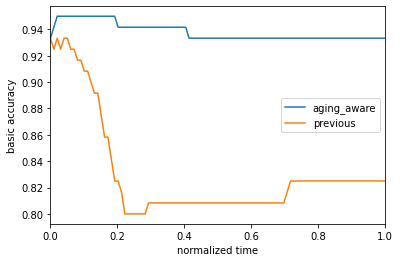

In [11]:
plt.plot(test_time, my_aged_acc, label='aging_aware');
plt.plot(test_time, my_acc, label='previous');
plt.xlabel('normalized time');
plt.ylabel('basic accuracy');
plt.xlim([0, 1]);
plt.legend();

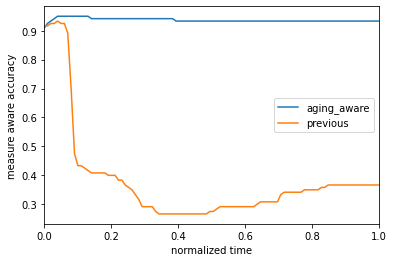

In [12]:
plt.plot(test_time, my_aged_maa, label='aging_aware');
plt.plot(test_time, my_maa, label='previous');
plt.xlabel('normalized time');
plt.ylabel('measure aware accuracy');
plt.xlim([0, 1])
plt.legend();